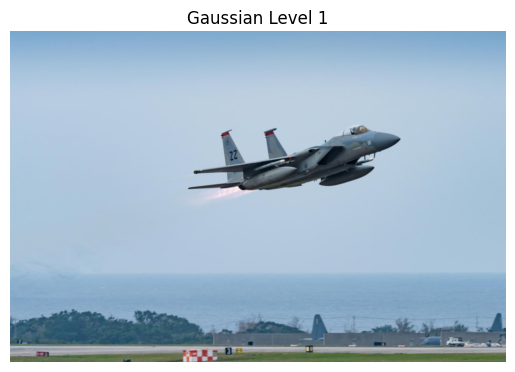

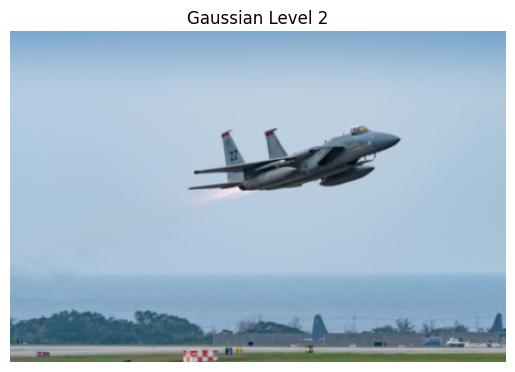

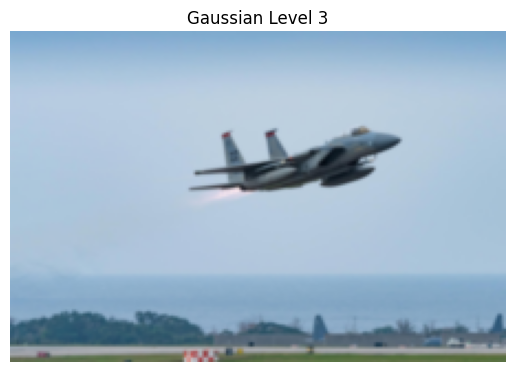

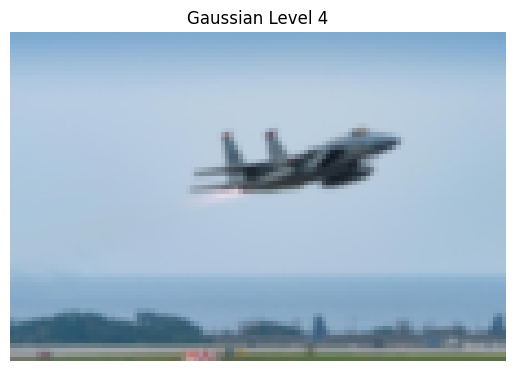

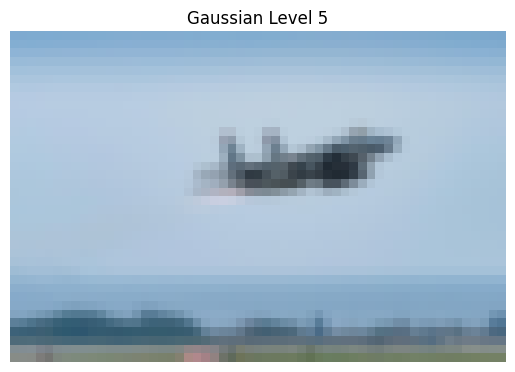

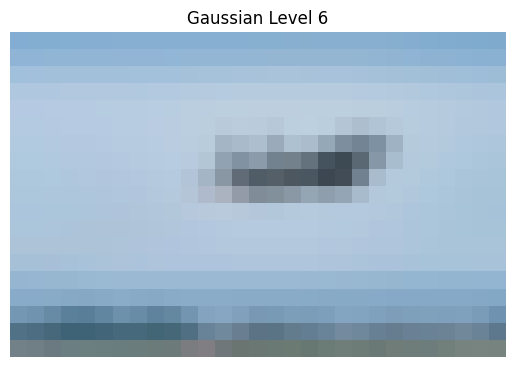

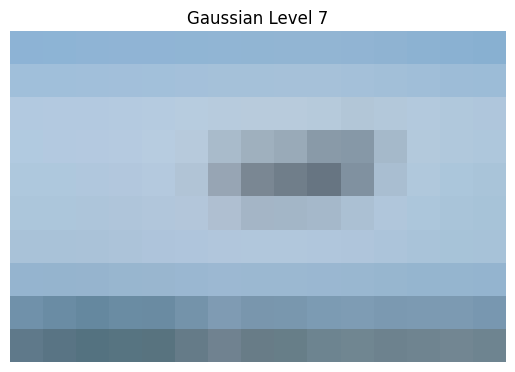

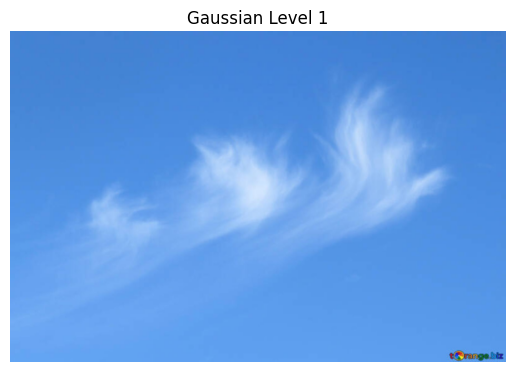

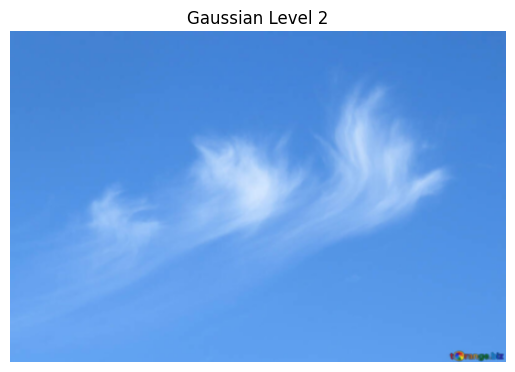

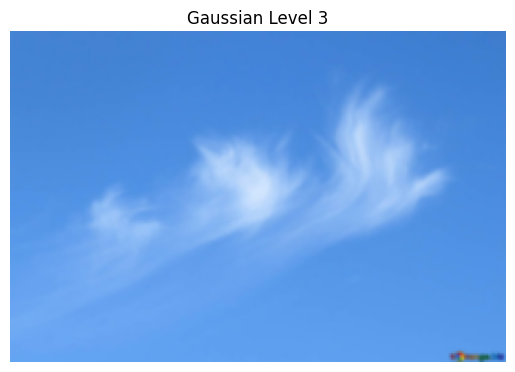

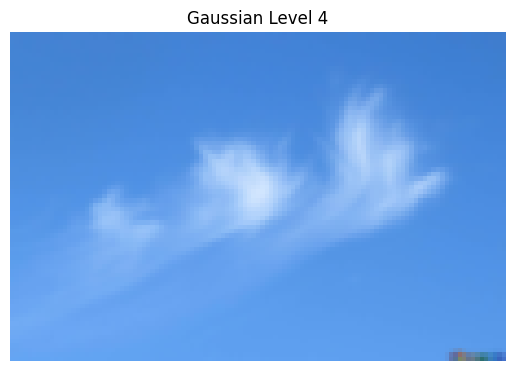

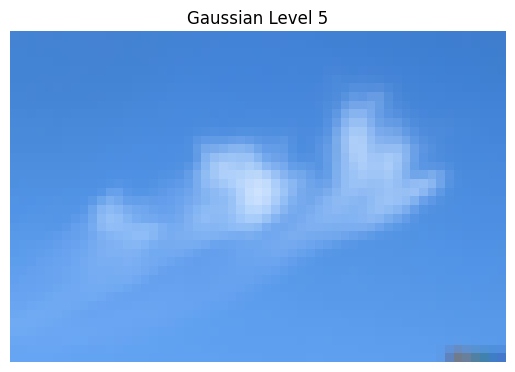

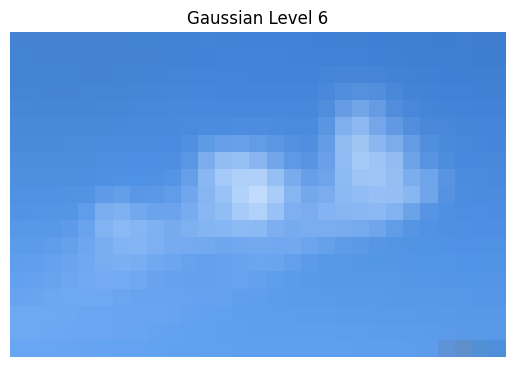

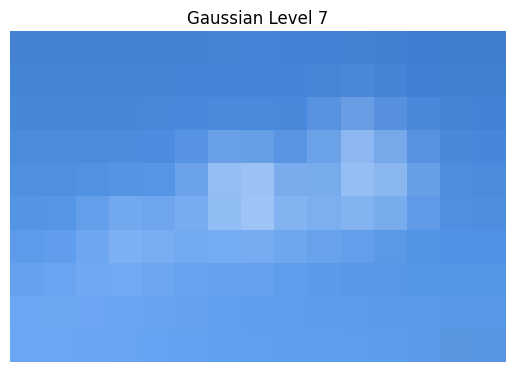

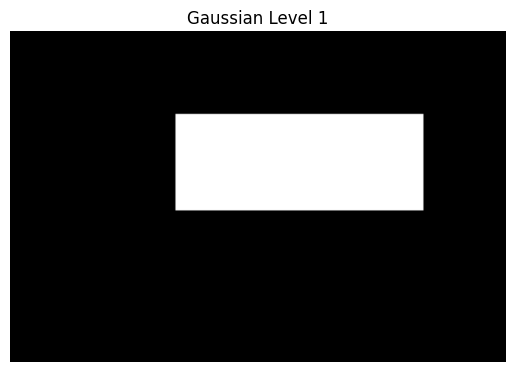

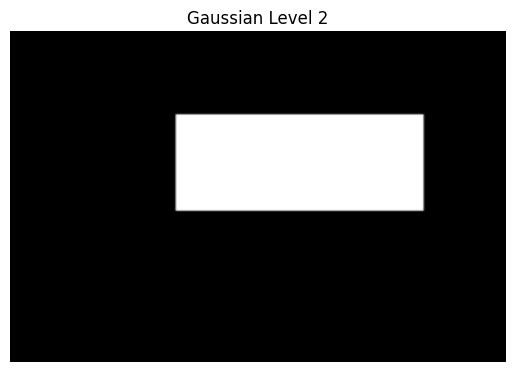

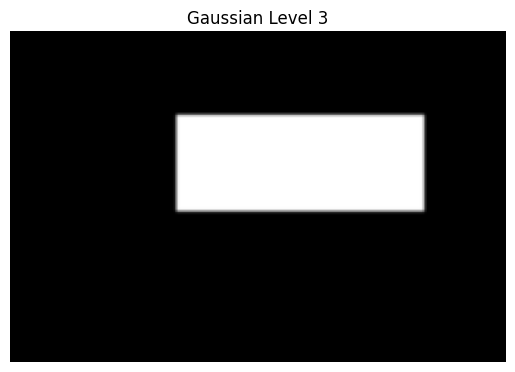

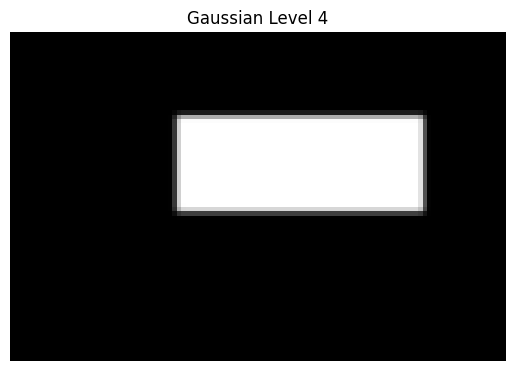

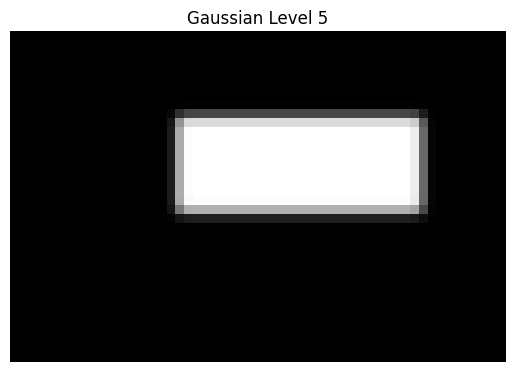

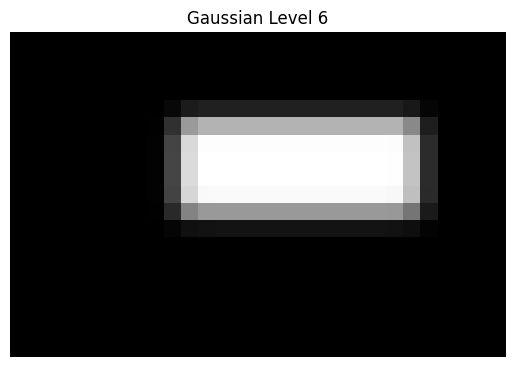

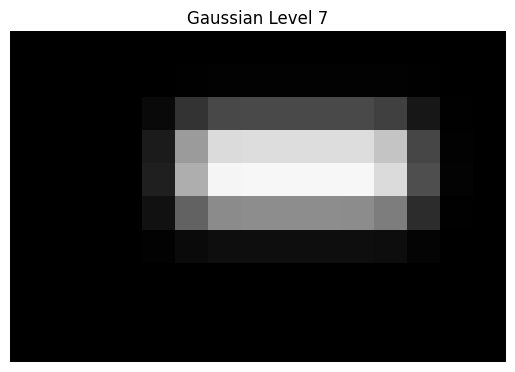

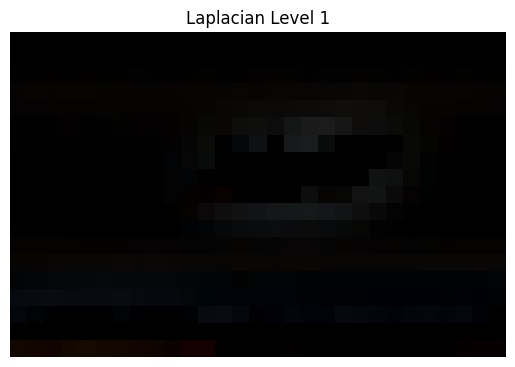

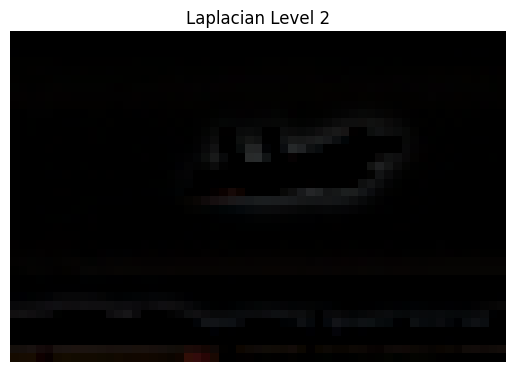

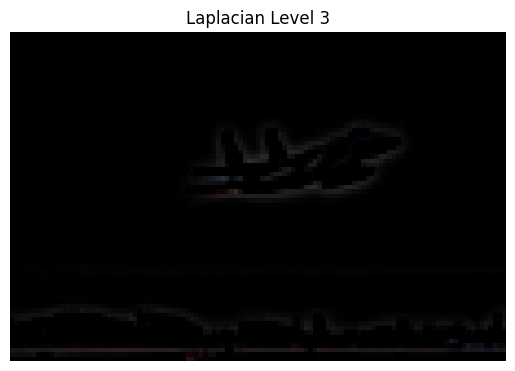

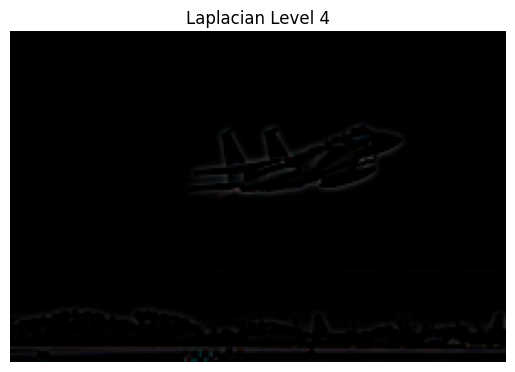

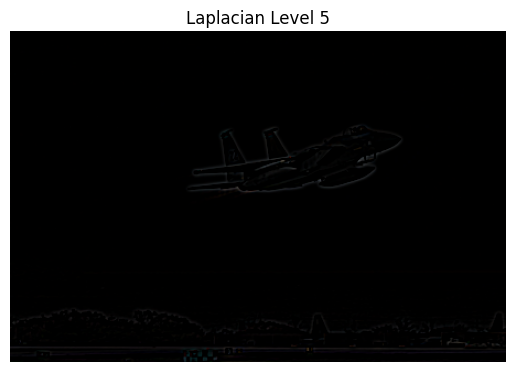

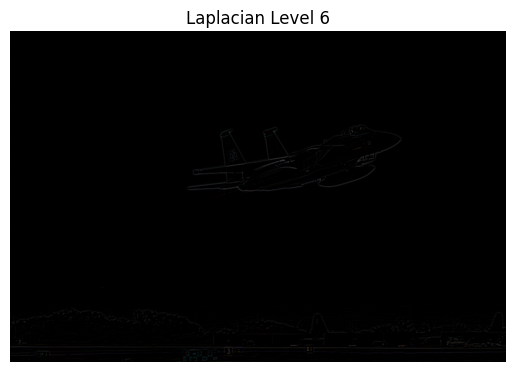

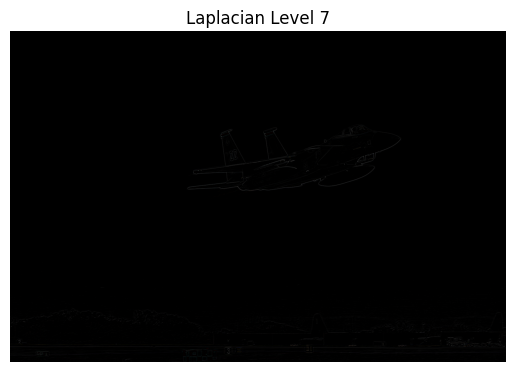

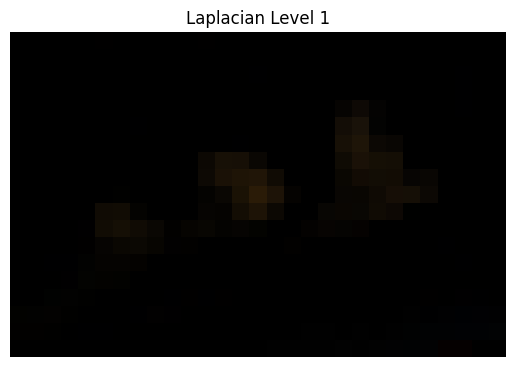

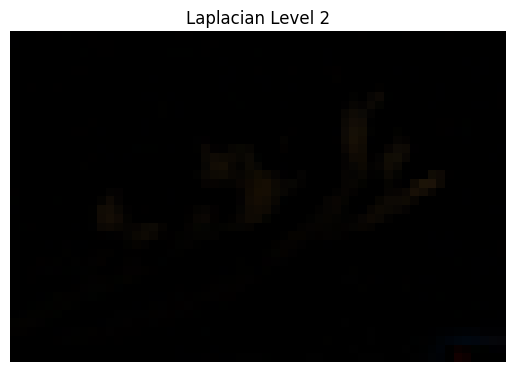

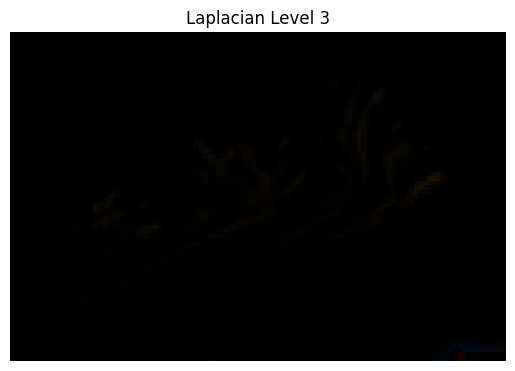

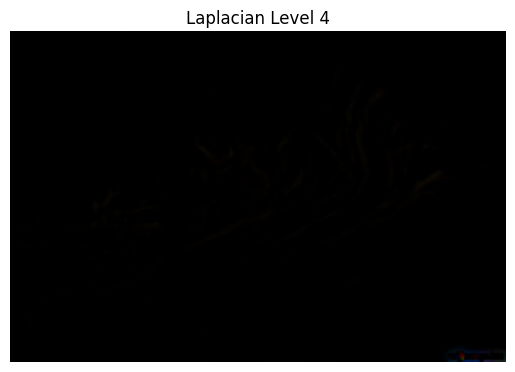

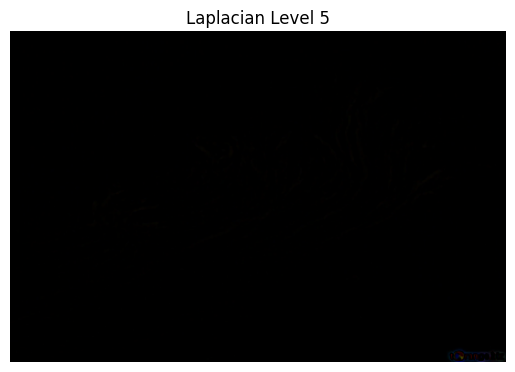

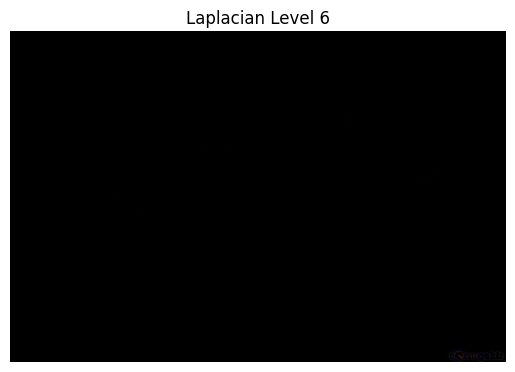

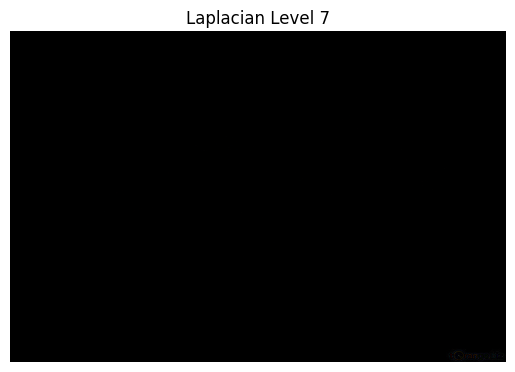

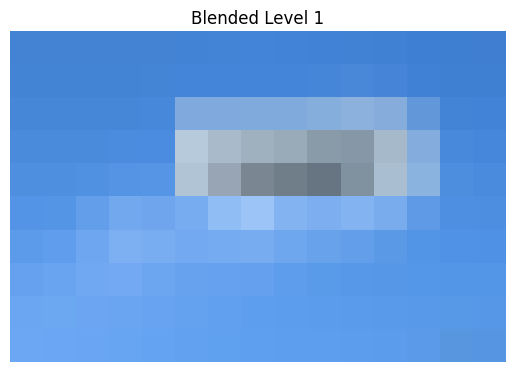

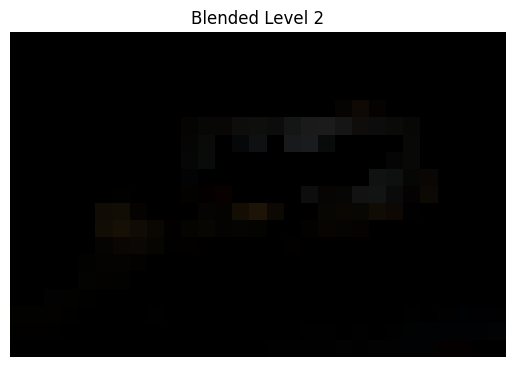

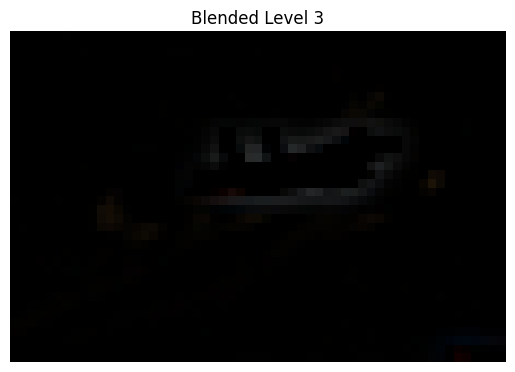

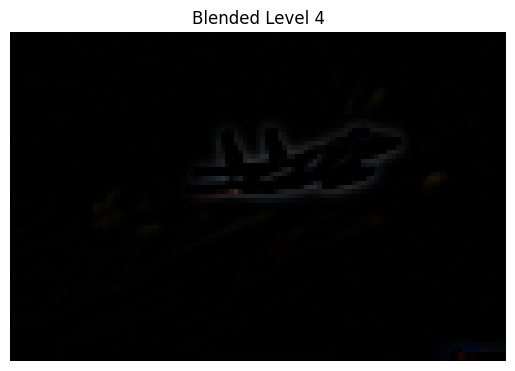

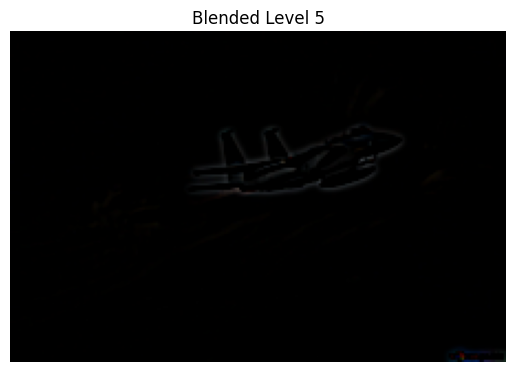

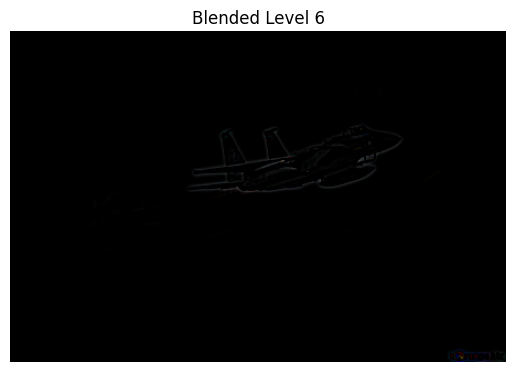

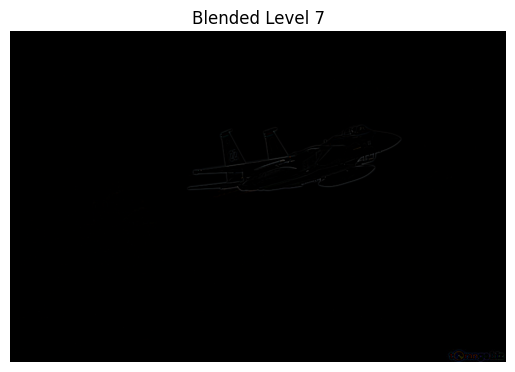

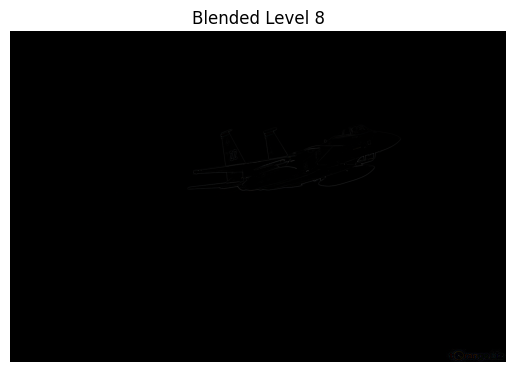

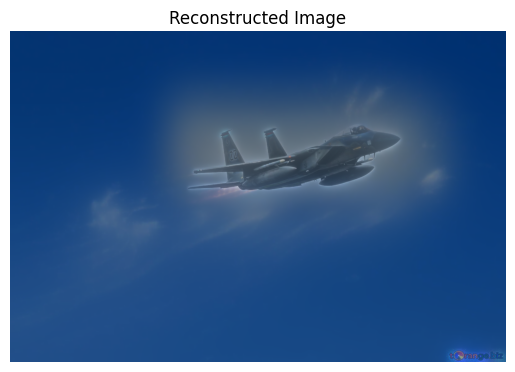

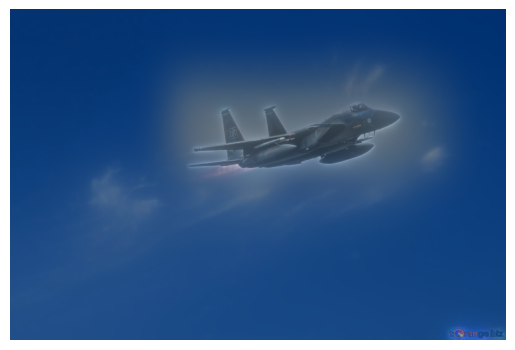

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Function to resize a mask to match image dimensions
def resize_mask(mask, shape):
    resized_mask = cv2.resize(mask, (shape[1], shape[0]))
    return np.repeat(resized_mask[:, :, np.newaxis], 3, axis=2).astype(float) / 255

# Function to generate Gaussian pyramid for an image
def build_gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
        # Display each level of the Gaussian pyramid
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'Gaussian Level {i+1}')
        plt.axis('off')
        plt.show()
    return pyramid

# Function to generate Laplacian pyramid from Gaussian pyramid
def build_laplacian_pyramid(gaussian_pyramid):
    pyramid = [gaussian_pyramid[-1]]
    for i in range(len(gaussian_pyramid) - 1, 0, -1):
        upsampled = cv2.pyrUp(gaussian_pyramid[i], dstsize=(gaussian_pyramid[i - 1].shape[1], gaussian_pyramid[i - 1].shape[0]))
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], upsampled)
        pyramid.append(laplacian)
        # Display each level of the Laplacian pyramid
        plt.imshow(cv2.cvtColor(laplacian, cv2.COLOR_BGR2RGB))
        plt.title(f'Laplacian Level {len(gaussian_pyramid) - i}')
        plt.axis('off')
        plt.show()
    return pyramid

# Function to blend two image pyramids
def blend_pyramids(pyramid1, pyramid2, mask_pyramid):
    blended = []
    for i, (layer1, layer2, mask) in enumerate(zip(pyramid1, pyramid2, mask_pyramid)):
        mask_resized = resize_mask(mask, layer1.shape)
        blended_layer = layer1 * (1 - mask_resized) + layer2 * mask_resized
        blended.append(blended_layer)
        # Display each level of the blended pyramid
        plt.imshow(cv2.cvtColor(blended_layer.astype(np.uint8), cv2.COLOR_BGR2RGB))
        plt.title(f'Blended Level {i+1}')
        plt.axis('off')
        plt.show()
    return blended


# Function to reconstruct image from a Laplacian pyramid
def reconstruct_image(pyramid):
    image = pyramid[0]
    for layer in pyramid[1:]:
        image = cv2.pyrUp(image, dstsize=(layer.shape[1], layer.shape[0]))
        image = cv2.add(image, layer)

    # Convert image to 8-bit format
    image_8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Display the final reconstructed image
    plt.imshow(cv2.cvtColor(image_8bit, cv2.COLOR_BGR2RGB))
    plt.title('Reconstructed Image')
    plt.axis('off')
    plt.show()

    return image_8bit


# Read images and mask
jet_img = cv2.imread('jet.jpeg')
cloud_img = cv2.imread('cloud.jpg')
mask = cv2.imread('mask.jpg', 0)

# Set the number of pyramid levels
pyramid_levels = 7

# Generate Gaussian and Laplacian pyramids
gaussian_pyramid_jet = build_gaussian_pyramid(jet_img, pyramid_levels)
gaussian_pyramid_cloud = build_gaussian_pyramid(cloud_img, pyramid_levels)
gaussian_pyramid_mask = build_gaussian_pyramid(mask, pyramid_levels)

laplacian_pyramid_jet = build_laplacian_pyramid(gaussian_pyramid_jet)
laplacian_pyramid_cloud = build_laplacian_pyramid(gaussian_pyramid_cloud)

# Blend the pyramids and reconstruct the blended image
blended_pyramid = blend_pyramids(laplacian_pyramid_cloud, laplacian_pyramid_jet, gaussian_pyramid_mask)
blended_img = reconstruct_image(blended_pyramid)

# Normalize and save the blended image
normalized_img = cv2.normalize(blended_img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
cv2.imwrite('blended_image_normalized.jpg', normalized_img)

# Display the final blended image
blended_img_rgb = cv2.cvtColor(normalized_img, cv2.COLOR_BGR2RGB)
plt.imshow(blended_img_rgb)
plt.axis('off')
plt.show()

